In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

One problem in route flow inference from cellular network data is how to match a
user's cell traces to a cellpath corresponding to a route. The latter cellpath
is generated by finding all cells passing through a route, while the former
cellpath is collected from a user's phone connection to cell towers.

A user's cellpath can be noisy and even discontinuous, yet we need to establish
a means of finding the best match between this cellpath and all the other
cellpaths defined by the multiple routes in order to generate the $f$ matrix in
$Ux=f$.

One way to determine how close two cellpaths are to each other is to view them
as sets of cells, and use the Jacquard distance to measure similarity between
sets. For sets $A$ and $B$, the Jacquard distance is:

$$J(A, B) \equiv \frac{|A \cap B|}{|A \cup B|}$$,

the ratio between their intersection and their union. Its value ranges from 0 to
1, corresponding to disjoint sets and two equal sets respectively. Besides being
normalized and easy to compute, there is another motivation for choosing this
metric. There are around the order of 1 million of both types of cellpaths, to
match them using the naive $O(n^2)$ algorithm would be way too slow. We need a
sublinear-time method of performing each match. 

Denote the universe (set of all cells) as $U$. Suppose we have a hash function
$h$ with domain $U$. We define:

$$h_\text{min}(A) \equiv \min \{ h(x) \mid x \in A \}$$

The following result holds if $h$ is a random permutation on $U$:

$$\Pr(h_\text{min}(A) = h_\text{min}(B)) = J(A, B)$$

We want to use this fact to create a _locality-sensitive hash_, a hash where two
sets with high Jacquard distance have a high probability of being hashed into
the same bucket. To do this, we first create $k * b$ random hash functions, and
for each set $A_i$ we compute a column vector of minhashes for all of these hash
functions. We concatenate each block of $b$ minhashes for each column vector,
and insert each set into $k$ hash tables, finding the bucket using the
concatenated hashes from each row.

    A_1  A_2     A_n
    +-+  +-+     +-+ ^    ^
    |h|  |h|     |h| | b  |
    |h|  |h|     |h| v    |
    |-|  |-|     |-| ^    |
    |h|  |h| ... |h| | b  | k * b
    |h|  |h|     |h| v    |
    |-|  |-|     |-| ^    |
    |h|  |h|     |h| | b  |
    |h|  |h|     |h| v    v
    +-+  +-+     +-+

To lookup a set $B$, we compute the column vector of minhashes, then for row $i$
get the corresponding bucket from the $i$-th hash table. We take the union of
all $k$ buckets in the end to get a (much smaller) collection of candidates, and
compare $B$ with each candidate.

Here we compute the probability  of a pair of sets with Jacquard distance $p$
ending up in the same bucket:

$$f(p) = 1-(1-p^k)^b$$

We also compute the probability threshold, which is the inflection point in this
function. It is given by:

$$\frac{d^2f}{dp^2} = 0$$
$$\left( \frac{(b-1)k}{k-1} + 1\right)^{-1/k} \approx b^{-1/k}$$


In [2]:
f = lambda p, b, k: 1 - (1 - p**k)**b
threshold = lambda b, k: ((b-1)*k/float(k-1)+1)**(-1.0/k)

We graph the threshold function for $b=7$ and $k=5$ used in the AT&T experiments. 

Threshold: 0.651802789631


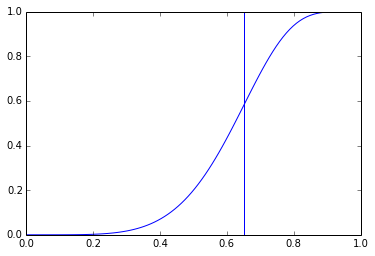

In [3]:
def plot(b, k):
    x = np.linspace(0, 1, 100)
    y = f(x, b, k)
    plt.plot(x, y, label='b={},k={}'.format(b, k))
    plt.axvline(x=threshold(b, k))
plot(7, 5)
print 'Threshold: ' + str(threshold(7, 5))

We can investigate how $b$ and $k$ affect the threshold function. We want to get
the best curve with the lowest $b*k$ value to reduce computation time. First we
create some helper plotting functions.

In [4]:
def plot_series(seq):
    plt.figure(figsize=(10,5))
    for b, k in seq:
        plot(b, k) 
    ax = plt.gca()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

We fix $b=5$ and vary $k$. Notice that $k$ mainly changes the false positive
rate.

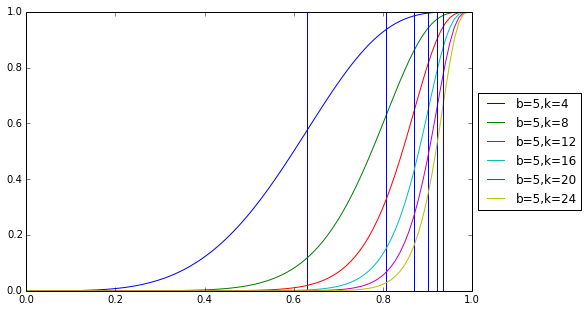

In [5]:
plot_series([(5, k) for k in range(4, 28, 4)])

Now we fix $k=5$ and vary $b$. Notice that $b$ mainly changes the false negative rate.

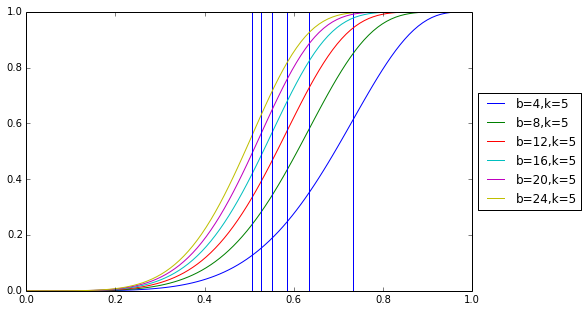

In [6]:
plot_series([(b, 5) for b in range(4, 28, 4)])

Now we fix $b*k=24$ and graph the respective thresholds.

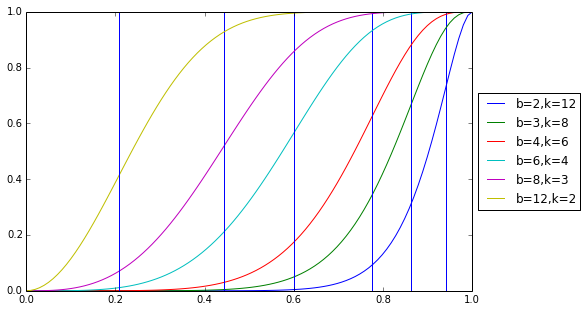

In [7]:
plot_series([(2, 12), (3, 8), (4, 6), (6, 4), (8, 3), (12, 2)])